<a href="https://colab.research.google.com/github/PaulPhSpr/Seminararbeit/blob/master/DeepPiCar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Das Notebook zum Training des DeepPiCar**

Dieser Quelltext ist adaptiert aus: Tian, David (2019). DeepPiCar - Part 5. Zuletzt abgerufen am 27.05.2020. Verfügbar unter: https://towardsdatascience.com/deeppicar-part-5-lane-following-via-deep-learning-d93acdce6110

# Teil 1 - Import der Bibliotheken

In [0]:
#--Standart-Bibliotheken--#
import os #zum Arbeiten mit Dateipfaden
import random 
import numpy as np

#--Machine Learning--#
import keras #High Lever Schnittstelle für Tensorflow
from keras.models import Model #zum Zusammenbauen
from keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dense #verschiedene Layer
from keras.optimizers import SGD #Stochastic Gradient Descent
from keras.models import load_model #für das Laden
from keras.preprocessing.image import ImageDataGenerator

#--Vorbereitung ML--#
from sklearn.model_selection import train_test_split #um den Datensatz aufzuteilen

#--Graphik--#
import cv2
from imgaug import augmenters as img_aug #Data Augmentation
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline 
from PIL import ImageFilter, Image #um Bilder zu bearbeiten und anzuzeigen

#--Auswertung--#
!pip3 install deeplearning2020
from deeplearning2020 import helpers #(OpenHPI, 2020)

#--Download--#
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth #Authentifizierung
from pydrive.drive import GoogleDrive #Drive
from google.colab import auth
from oauth2client.client import GoogleCredentials

Using TensorFlow backend.


     |████████████████████████████████| 399kB 6.6MB/s 
  Created wheel for deeplearning2020: filename=deeplearning2020-0.4.21-py2.py3-none-any.whl size=8548 sha256=8052333bca36667f90988e6b8cb9aa9e3da134c91772493ae8f0c4964d16825f
  Stored in directory: /root/.cache/pip/wheels/7f/c2/8a/f9f03fc839999f1fe9d5e5a9d2c97cdd5cb8329f61f82ea2c9
  Created wheel for kerasltisubmission: filename=kerasltisubmission-0.4.9-py2.py3-none-any.whl size=8867 sha256=b8a33b74aa09194d47dca5458ea83934320b9a2dfb17862a1e683e03e0fc5329
  Stored in directory: /root/.cache/pip/wheels/fd/61/f7/09171376b25408ae21b58e98c9fbf2eb924f676bb77659f983
Successfully built deeplearning2020 kerasltisubmission


# Teil 2 - Download der Daten

In [0]:
#--Daten aus GitHub herunterladen--#
!cd /content
!git clone https://github.com/PaulPhSpr/Seminararbeit 

Cloning into 'Seminararbeit'...
remote: Enumerating objects: 2279, done.
remote: Total 2279 (delta 0), reused 0 (delta 0), pack-reused 2279
Receiving objects: 100% (2279/2279), 43.69 MiB | 40.12 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [0]:
#--Speicherorte angeben--#
!ls
bas_dir = "Seminararbeit/Datensatz"
train_dir = os.path.join(bas_dir, "train")
valid_dir = os.path.join(bas_dir, "valid")

sample_data  Seminararbeit


# Teil 3 - Data Augmentation

In [0]:
#--Zoom--#
def zoom(bild):
  zoom = img_aug.Affine(scale=(1, 1.3)) #zufälliger zoom zwischen 100% und 130%
  bild = zoom.augment_image(bild)
  return bild

#--Rotation um 180°--#
def flip(bild, steuerwinkel):
  flipJa = random.randint(0,1)
  if flipJa == 1:
    bild = cv2.flip(bild, 1)
    steuerwinkel = 180 - steuerwinkel #durch Rotation verändert sich der Steuerwinkel --> Gegenwinkel
  return bild, steuerwinkel

#--Unschärfe--#
def blur(bild):
  kernel = random.randint(1,5) #alles darüber zu verschwommen
  bild = cv2.blur(bild, (kernel, kernel))
  return bild

def hell(bild):
  helligkeit = img_aug.Multiply((0.7, 1.3)) #70%-130%
  bild = helligkeit.augment_image(bild)
  return bild

#--Zusammenbringen--#
def augmentation(bild, steuerwinkel):
  if np.random.rand() < 0.5:
    bild = zoom(bild)
  if np.random.rand() < 0.5:
    bild = blur(bild)
  if np.random.rand() < 0.5:
    bild = hell(bild)
  #if np.random.rand() < 0.5:
    #bild, steuerwinkel = flip(bild, steuerwinkel)
  return bild, steuerwinkel

# Teil 4 - Daten vorbereiten für Training

In [0]:
#--Aus Array von Arrays ein Array aus Bildern--#
def toBild(bild):
  bild = Image.fromarray((bild).astype(np.uint8)) #nur dieses Dateiformat wird von Pillow akzeptiert
  bild = cv2.cvtColor(np.array(bild), cv2.COLOR_BGR2RGB) #in numpy bild umwandeln
  return bild

#--Bilder standardisieren--#
def vorbereitung_bild(bild):
  bild = toBild(bild)
  return bild

#--Aus Categorical zu Numeric, [0, 0, 1, 0] --> 2
def vorbereitung_steuerwinkel(winkel):
  for i in range(10): #10 klassen
    if winkel[i] != 0:
      return i

#--Bildgenerator für Trainingsprozess--#
def bild_dat_generator(bilder, steuerwinkel, trainiert):
  batch_bild = []
  batch_steuerwinkel = []

  #so viele Bilder wie angeben ausgeben
  for i in range(len(bilder)):
    rand_i = random.randint(0, len(bilder)-1) #ein Bild aussuchen
    bild = bilder[rand_i]
    bild = vorbereitung_bild(bild)
    str_winkel = steuerwinkel[rand_i]
     
    #Augmentation
    if(trainiert):
      bild, str_winkel = augmentation(bild, str_winkel)

    bild = cv2.cvtColor(bild, cv2.COLOR_BGR2RGB)
    #Abspeichern
    batch_bild.append(bild)
    str_winkel = vorbereitung_steuerwinkel(str_winkel)
    batch_steuerwinkel.append(str_winkel)

  return np.asarray(batch_bild), np.asarray(batch_steuerwinkel)

In [0]:
#--Batches--#
classes = ["class" + str(i) for i in range(1, 11)]
train_batches = ImageDataGenerator().flow_from_directory(train_dir, target_size = (108, 146), classes=classes, batch_size = 1723) 
valid_batches = ImageDataGenerator().flow_from_directory(valid_dir, target_size = (108, 146), classes=classes, batch_size = 431)

Found 1723 images belonging to 10 classes.
Found 431 images belonging to 10 classes.


In [0]:
#--Trainingsdaten zusammenführen--#
#Trainingsdaten
bilder, label = next(train_batches)
X_train, y_train = bild_dat_generator(bilder, label, True)
#Validierungsdaten
bilder, label = next(valid_batches)
valid_data = bild_dat_generator(bilder, label, False)

# Teil 5 - Baue Modell

In [0]:
def baue_model():
  #--Params--#
  lr = 0.00005 #Learning Rate
  momentum = 0.9 #Parameter für SGD, entspricht Trägheit beim Abstieg
  dense_neurons = 1000

  activation = "elu" #Aktivierungsfunktion

  input_layer = Input(shape=(108, 146, 3)) #146x108px, 3 Farbkanäle

  #--Convultional Layers--#
  model = Conv2D(filters = 320, kernel_size = (5, 5), activation = activation, padding="same") (input_layer)
  model = MaxPooling2D((2,2)) (model)
  model = Conv2D(filters = 394, kernel_size = (5, 5), activation = activation, padding="same") (model)
  model = MaxPooling2D((2,2)) (model)
  model = Conv2D(filters = 458, kernel_size = (5, 5), activation = activation, padding="same") (model)
  model = MaxPooling2D((2,2)) (model)
  model = Conv2D(filters = 522, kernel_size = (3, 3), activation = activation, padding="same") (model)
  model = MaxPooling2D((2,2)) (model)
  model = Conv2D(filters = 586, kernel_size = (3, 3), activation = activation, padding="same") (model)
  model = MaxPooling2D((2,2)) (model)

  #--Dense Layers--#
  model = Flatten() (model)
  model = Dense(dense_neurons, activation=activation) (model)
  model = Dense(dense_neurons // 2, activation="tanh") (model)

  #--Output--#
  out = Dense(10, activation = "softmax") (model)
  CNN_model = Model(input_layer, out)

  #--Wie lernen?--#
  optimizer = SGD(lr=lr, momentum=momentum)

  #--Kompilieren und Ausgeben--#
  CNN_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

  return CNN_model

model = baue_model()
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 108, 146, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 146, 320)     24320     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 73, 320)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 54, 73, 394)       3152394   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 36, 394)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 36, 458)       4511758   
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 18, 458)       0   

# Teil 6 - Das Modell trainieren

Train on 1723 samples, validate on 431 samples
Epoch 1/30
1723/1723 [==============================] - 52s 30ms/step - loss: 1.1100 - accuracy: 0.5699 - val_loss: 0.8820 - val_accuracy: 0.6937
Epoch 2/30
1723/1723 [==============================] - 29s 17ms/step - loss: 0.8536 - accuracy: 0.7040 - val_loss: 0.8424 - val_accuracy: 0.6613
Epoch 3/30
1723/1723 [==============================] - 29s 17ms/step - loss: 0.7799 - accuracy: 0.7382 - val_loss: 0.8135 - val_accuracy: 0.6613
Epoch 4/30
1723/1723 [==============================] - 30s 17ms/step - loss: 0.7273 - accuracy: 0.7545 - val_loss: 0.7310 - val_accuracy: 0.7749
Epoch 5/30
1723/1723 [==============================] - 29s 17ms/step - loss: 0.6937 - accuracy: 0.7719 - val_loss: 0.6778 - val_accuracy: 0.7796
Epoch 6/30
1723/1723 [==============================] - 29s 17ms/step - loss: 0.6827 - accuracy: 0.7661 - val_loss: 0.6327 - val_accuracy: 0.7796
Epoch 7/30
1723/1723 [==============================] - 30s 17ms/step - loss:

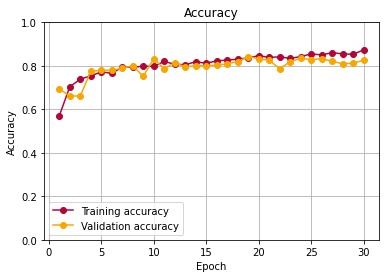

In [0]:
#--Training--#
history = model.fit(
    X_train, y_train, #Trainingsdaten generieren
    validation_data = valid_data, #Validierungsdaten generieren
    epochs = 30, #anzahl durchgänge
)

#--Trainings und Validierungsgenauigkeit anzeigen--#
helpers.plot_history("Accuracy", history, 0)

#--Abspeichern--#
model.save('DeepPiCar.h5')

# Teil 7 - Evaluieren

In [0]:
#--kategorisch in numerisch umwandeln--#
def auswertung_steuerwinkel(y):
  max = 0
  for i in range(len(y)):
    if(y[i] > y[max]):
      max = i
  return max 

#--Vorhersagen--#
def vorhersage(X):
  model = load_model('DeepPiCar.h5')
  y_pred = model.predict(X)
  return y_pred

In [0]:
#--Testdaten generieren--#4
bs = 5
test_batches = ImageDataGenerator().flow_from_directory(valid_dir, target_size = (108, 146), classes=classes, batch_size = bs)
X_test, y_test = next(test_batches)
y_pred = vorhersage(X_test)

Found 431 images belonging to 10 classes.


Gemessener Winkel = 60, Vorhergesagter Winkel = 80


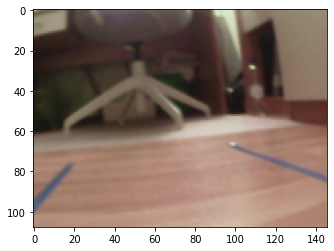

In [0]:
#--Anzeigen--#
num = random.randint(0, bs - 1)
gemessener_winkel = vorbereitung_steuerwinkel(y_test[num]) * 20
ausgewerteter_winkel = auswertung_steuerwinkel(y_pred[num]) * 20
print(f"Gemessener Winkel = {gemessener_winkel}, Vorhergesagter Winkel = {ausgewerteter_winkel}")
plt.imshow(X_test[num] / 255) #damit werte von 0 bis eins sind

# Teil 8 - Das Model herunterladen

Links auf das Icon mit dem Datei-Symbol klicken. "DeepPiCar.h5" auswählen und herunterladen. Weil die Datei >100MB ist, kann dieser der Download dauern.